# Introduction

This notebook compares the test set performance of classifiers using term list scores based on the data-driven, RDoC, and DSM frameworks.

# Load the data

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import sys
sys.path.append("..")
import utilities

## Input parameters

In [2]:
metric = "mod" # Variable being compared between frameworks
n_iter = 1000 # Number of iterations for bootstrap distributions
frameworks = ["data-driven", "rdoc", "dsm"]
clfs = ["_lr", "", ""]
splits = ["discovery", "replication"]
suffix = "lr"

## Framework contents

In [3]:
lists, circuits = {}, {}
for fw, clf in zip(frameworks, clfs):
    lists[fw], circuits[fw] = utilities.load_framework(fw, suffix=utilities.suffix[fw], clf=clf)

## Observed values

In [4]:
obs = {}
for fw, clf in zip(frameworks, clfs):
    obs[fw] = pd.read_csv("data/{}_obs_{}{}.csv".format(metric, fw, clf), 
                                index_col=0, header=0)

## Bootstrap distributions

In [5]:
boot, mean = {}, {}
for split in splits:
    boot[split], mean[split] = {}, {}
    for fw, clf in zip(frameworks, clfs):
        boot[split][fw] = pd.read_csv("data/{}_boot_{}{}_{}_{}iter.csv".format(metric, fw, clf, split, n_iter), 
                                index_col=0, header=0)
        mean[split][fw] = pd.read_csv("data/{}_mean_{}{}_{}.csv".format(metric, fw, clf, split), 
                                index_col=0, header=0)

# Perform comparison tests

Is the mean of fw<sub>i</sub> greater than the mean of fw<sub>j</sub>?

In [6]:
from statsmodels.stats.multitest import multipletests

In [7]:
p, fdr = {}, {}
for split in splits:
    p[split] = np.empty((len(frameworks), len(frameworks)))
    for i, fw_i in enumerate(frameworks):
        for j, fw_j in enumerate(frameworks):
            boot_i = np.mean(boot[split][fw_i], axis=0)
            boot_j = np.mean(boot[split][fw_j], axis=0)
            p[split][i,j] = np.sum((boot_i - boot_j) <= 0.0) / float(n_iter)

    fdr[split] = multipletests(p[split].ravel(), method="fdr_bh")[1].reshape(p[split].shape)
    fdr[split] = pd.DataFrame(fdr[split], index=frameworks, columns=frameworks)
    
    print("-" * 65 + "\n" + split.upper() + "\n" + "-" * 65)
    print(fdr[split])
    print("")

-----------------------------------------------------------------
DISCOVERY
-----------------------------------------------------------------
             data-driven  rdoc    dsm
data-driven          1.0   0.0  0.003
rdoc                 1.0   1.0  1.000
dsm                  1.0   0.0  1.000

-----------------------------------------------------------------
REPLICATION
-----------------------------------------------------------------
             data-driven  rdoc  dsm
data-driven          1.0   0.0  1.0
rdoc                 1.0   1.0  1.0
dsm                  1.0   0.0  1.0



# Plot evaluation metrics

In [8]:
%matplotlib inline

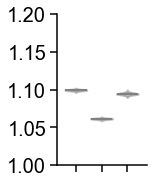

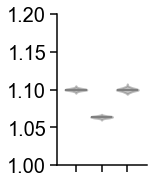

In [9]:
for split in splits:
    utilities.plot_framework_comparison(boot[split], obs, mean[split], metric=metric, 
                                        n_iter=n_iter, suffix=suffix + "_" + split, 
                                        ylim=[1,1.2], yticks=[1,1.05,1.1,1.15,1.2])